# Imports

In [1]:
from helpers import *
import os
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns

from bs4 import BeautifulSoup # To Extract all the URLs from the HTML page


import networkx as nx
import matplotlib.pyplot as plt
import csv
from urllib.parse import unquote
import matplotlib._color_data as mcd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## NDLM'ADA - Look up ! Stars and how we them
#### *Timo Achard, Romane Clerc, Louise Font, Julie Korber, Emeric Martin*
Supplementary notebook containing additional data exploration and analysis not usefull for the main pipeline of our project. 

# Table of contents
* [Downloading the data](#section0)
    * [Downloading the dataset](#subsection0_1)
    * [Function](#subsection0_2)
    * [Format & missing values](#subsection0_3)
        * [Finished paths](#subsection0_3_1)
        * [Unfinished paths](#subsection0_3_2)
        * [Categories](#subsection0_3_3)
        * [Article](#subsection0_3_4) 
        * [Links](#subsection0_3_5)
* [Position of the links in each article pages](#section1)
    * [Extraction of the links position](#subsection1_1)
    * [Distribution of the links by their position categories](#subsection1_2)
    * [Linkage with the frequence of visit](#subsection1_3)
* [Creation of a networkX with target people and all the path that lead to it](#section2)




# 0. Downloading the data & preprocessing <a classe="anchor" id="section0"></a>

## 0.1. Downloading the dataset <a classe="anchor" id="subsection0_1"></a>

In [2]:
# Paths
folder_path = "dataset/wikispeedia_paths-and-graph/"
file_paths = ["paths_finished.tsv", "paths_unfinished.tsv", "categories.tsv", "articles.tsv", "links.tsv"]

# Datasets: Names and their columns name
data_frames_names = ["paths_finished", "paths_unfinished", "categories", "article", "links"]
dfs_headers = [
    ["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    ["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
    ["article", "category"],
    ["article"],
    ["linkSource", "linkTarget"]
]

# Download
dfs_skiprows = [16, 17, 13, 12, 12]
dfs = {}
for i in range(len(file_paths)):
    dfs[data_frames_names[i]] = pd.read_csv(folder_path + file_paths[i], sep='\t', header=None, names=dfs_headers[i], skiprows=range(dfs_skiprows[i]))

## 0.2. Function <a classe="anchor" id="subsection0_2"></a>

In [3]:
def dataset_info(dictionary, dataset_name):
    """ Display main information about a specified dataset from the given dictionary.
    params:
        dictionnary: dict
            A dictionary of dataframes.
        dataset_name: str 
            The name of the dataframe to be accessed in the dictionary
     """
    # Print the dataset name we are working on
    print('{}:'.format(dataset_name))

    df = dictionary[dataset_name]
    print('\tShape of the dataset: {}'.format(df.shape))
    

     # Check for NaN values in each column
    columns_with_nan = df.columns[df.isna().any()].tolist()

    # Print the columns with NaN values if they exsit
    if columns_with_nan == []:
        print('\tThe dataset has no column with NaN values.\n')
    else:
        print('\tThe dataset has {} columns with NaN values: {}\n'.format(len(columns_with_nan), columns_with_nan))
    
    # Provide statistical info 
    print('Visualisation of the first column and statistical infos:')
    display(df.head(1))
    display(df.describe(include='all'))
    df.info()

## 0.3. Format & missing values <a classe="anchor" id="subsection0_3"></a>

### Finished paths dataset <a classe="anchor" id="subsection0_3_1"></a>

In [4]:
dataset_info(dfs, 'paths_finished')

paths_finished:
	Shape of the dataset: (51318, 5)
	The dataset has 2 columns with NaN values: ['hashedIpAddress', 'rating']

Visualisation of the first column and statistical infos:


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN


,hashedIpAddress,timestamp,durationInSec,path,rating
count,51315,5.131800e+04,51318.000000,51318,28501.000000
unique,14244,NaN,NaN,47856,NaN
top,0d57c8c57d75e2f5,NaN,NaN,Brain;Computer_science;Information;Communicati...,NaN
freq,4865,NaN,NaN,144,NaN
mean,NaN,1.296384e+09,158.276199,NaN,2.269780
std,NaN,4.935086e+07,360.841904,NaN,1.110439
min,NaN,1.219095e+09,0.000000,NaN,1.000000
25%,NaN,1.250109e+09,60.000000,NaN,1.000000
50%,NaN,1.283894e+09,107.000000,NaN,2.000000
75%,NaN,1.345231e+09,183.000000,NaN,3.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51318 entries, 0 to 51317
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hashedIpAddress  51315 non-null  object 
 1   timestamp        51318 non-null  int64  
 2   durationInSec    51318 non-null  int64  
 3   path             51318 non-null  object 
 4   rating           28501 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.0+ MB


#### Observations

- The *finish path* dataset consists of 5 columns: 
    - **hashedIpAddress:** The IP adresses that allows to identify different players. 
    - **timestamp:**  A sequence of characters indicating the current time of an event, in this case, playing Wikispeedia, recorded by the computer.
    - **durationInsec:** The duration it tooks for the player to link the source article to the target. 
    - **path:** Each path taken to link a source article to the target.
    - **rating:** An optional evaluation made by the player to assess the difficulty encountered in linking the source to the target article.

* From the count and unique information, the following observations can be made:
    * There are 14,244 unique hashedIpAddress out of 51,315 Ip addresses, meaning that the users are playing the game multiple times. 
    * Some players are taking the same path as there are 47,856 unique paths out of 51,318. 
    
- The dataset contains missing values in hashedIpAddress and rating columns. For our analysis, we will not use the information from those two columns, so handling missing values is not necessary for now. Therfore we will just remove those columns from the dataset for the further analysis. If needed, one option for handling missing values in hashedIpAddress is to remove corresponding rows, as only 3 out of 51,318 values are missing. For the rating missing values, around 55% of the values are missing, simply removing them may result in a significant reduction in the dataset size and introduce bias. A better approach would be to predict their values and replace the NaN entries with those predictions or replace NaN with another value manageable for the task at hand.

- We observed that in the path column, some characters are not correctly translated (%.. format). We need to correct them.

#### Adjustments

In [5]:
dfs = change_characters(dfs, 'paths_finished', 'path')
dfs['paths_finished'] = dfs['paths_finished'].drop(['hashedIpAddress', 'rating'], axis = 1)
display(dfs['paths_finished'])

,timestamp,durationInSec,path
0,1297740409,166,14th_century;15th_century;16th_century;Pacific...
1,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...
2,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...
3,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece
4,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...
...,...,...,...
51313,1349231015,66,Yagan;Ancient_Egypt;Civilization
51314,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...
51315,1385095372,228,Yagan;Australia;England;France;United_States;T...
51316,1298792567,56,"Yarralumla,_Australian_Capital_Territory;Austr..."


### Unfinished paths dataset <a classe="anchor" id="subsection0_3_2"></a>

In [6]:
dataset_info(dfs, 'paths_unfinished')

paths_unfinished:
	Shape of the dataset: (24875, 6)
	The dataset has no column with NaN values.

Visualisation of the first column and statistical infos:


,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout


,hashedIpAddress,timestamp,durationInSec,path,target,type
count,24875,2.487500e+04,24875.000000,24875,24875,24875
unique,11485,NaN,NaN,20982,3766,2
top,26f76e394525328e,NaN,NaN,Brain,Telephone,restart
freq,163,NaN,NaN,213,1060,15552
mean,NaN,1.344763e+09,835.296884,NaN,NaN,NaN
std,NaN,2.772317e+07,881.287961,NaN,NaN,NaN
min,NaN,1.297055e+09,4.000000,NaN,NaN,NaN
25%,NaN,1.320339e+09,86.000000,NaN,NaN,NaN
50%,NaN,1.348587e+09,261.000000,NaN,NaN,NaN
75%,NaN,1.367373e+09,1831.000000,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24875 entries, 0 to 24874
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   hashedIpAddress  24875 non-null  object
 1   timestamp        24875 non-null  int64 
 2   durationInSec    24875 non-null  int64 
 3   path             24875 non-null  object
 4   target           24875 non-null  object
 5   type             24875 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


#### Observations

- The *unfinish path* dataset consists of 6 columns: 
    - **hashedIpAddress:** The IP adresses that allows to identify different players. 
    - **timestamp:**  A sequence of characters indicating the current time of an event, in this case, playing Wikispeedia, recorded by the computer.
    - **durationInsec:** The duration it tooks for the player to link the source article to the target. 
    - **path:** Each path taken to link a source article to the target.
    - **target:** The name of the target article the player would ideally reach.
    - **type:** The reason for which the path is unfinished, categorized into two types: timeout and restart.

* From the count and unique information, the following observations can be made:
    * There as for the finished paths, since there is a smaller number of unique hashedIpAddress than the total count, we can conclude that users are playing the game multiple times. 
    * Some players are taking the same path. The most represented unfinished path is *brain* (a path consisting of only one article), implying that some unfinished paths may result from players that do not like the source and target combination and choosing to restart.
    
 - There are no missing values. 

- We observed that in the path and target columns, some characters are not correctly translated (%.. format). We need to correct them.

#### Adjustments

In [7]:
dfs = change_characters(dfs, 'paths_unfinished', 'path')
dfs = change_characters(dfs, 'paths_unfinished', 'target')
display(dfs['paths_unfinished'])

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
...,...,...,...,...,...,...
24870,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart
24871,232f992e57d43e8d,1389787697,6,Modern_history,Hollandic,restart
24872,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,The_Beatles,timeout
24873,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout


### Categories dataset <a classe="anchor" id="subsection0_3_3"></a>

In [8]:
dataset_info(dfs, 'categories')

categories:
	Shape of the dataset: (5204, 2)
	The dataset has no column with NaN values.

Visualisation of the first column and statistical infos:


,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...


,article,category
count,5204,5204
unique,4598,129
top,Pottery,subject.Countries
freq,3,229


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5204 entries, 0 to 5203
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   5204 non-null   object
 1   category  5204 non-null   object
dtypes: object(2)
memory usage: 81.4+ KB


In [9]:
dfs = preprocessing()

#### Observations

- The _categories_ dataset consists of 2 columns: 
    - **article:** The name of the article.
    - **category:**  The corresponding categories to which the articles belong. The category is a sequence of sub-categories separated by a point.

* From the count and unique information, the following observations can be made:
    * There are 4,598 unique articles out of 5,204, meanings some articles have more than one category path within the 129 possible. 
    
 - There are no missing values. 

- We observed that in the article columns, some characters are not correctly translated (%.. format). We need to correct them. To be sure there are no similar issues in the category column, we will also check and correct them.


#### Adjustments

In [10]:
dfs = change_characters(dfs, 'categories', 'article')
dfs = change_characters(dfs, 'categories', 'category')
display(dfs['categories'])

,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists
...,...,...
5199,Zirconium,subject.Science.Chemistry.Chemical_elements
5200,Zoroaster,subject.People.Religious_figures_and_leaders
5201,Zuid-Gelders,subject.Geography.European_Geography
5202,Zuid-Gelders,subject.Language_and_literature.Languages


### Article dataset <a classe="anchor" id="subsection0_3_4"></a>

In [11]:
dataset_info(dfs, 'article')

article:
	Shape of the dataset: (4604, 1)
	The dataset has no column with NaN values.

Visualisation of the first column and statistical infos:


,article
0,Áedán_mac_Gabráin


,article
count,4604
unique,4604
top,Áedán_mac_Gabráin
freq,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4604 entries, 0 to 4603
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  4604 non-null   object
dtypes: object(1)
memory usage: 36.1+ KB


#### Observations

- The _article_ dataset consists of 1 column: 
    - **article:** The name of the article.

* There are 6,604 articles and no missing values.
    
- We observed that in the article columns, some characters are not correctly translated (%.. format). We need to correct them.

#### Adjustments


In [12]:
dfs = change_characters(dfs, 'article', 'article')
display(dfs['article'])


,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts
...,...
4599,Zionism
4600,Zirconium
4601,Zoroaster
4602,Zuid-Gelders


### Links dataset <a classe="anchor" id="subsection0_3_5"></a>

In [13]:
dataset_info(dfs, 'links')

links:
	Shape of the dataset: (119882, 2)
	The dataset has no column with NaN values.

Visualisation of the first column and statistical infos:


,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede


,linkSource,linkTarget
count,119882,119882
unique,4587,4135
top,United_States,United_States
freq,294,1551


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119882 entries, 0 to 119881
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   linkSource  119882 non-null  object
 1   linkTarget  119882 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


#### Observations

- The _links_ dataset consists of 2 columns: 
    - **linkSource:** The name of the source article.
    - **linkTarget:** The name of the target article.

* From the summary information, the following observations are be made:
    * The most represented source and target articles is in both case the _United_States_ article. 
    * There are no missing values. 

- We observed that in both columns, some characters are not correctly translated (%.. format). We need to correct them. 

#### Adjustments

In [14]:
dfs = change_characters(dfs, 'links', 'linkSource')
dfs = change_characters(dfs, 'links', 'linkTarget')
display(dfs['links'])

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
...,...,...
119877,Zulu,South_Africa
119878,Zulu,Swaziland
119879,Zulu,United_Kingdom
119880,Zulu,Zambia


### Pre-processing function for further analysis
A function summarizing the above preprocessing steps can be found in the [helpers.py](helpers.py) Python script. This function will be used in the further analysis.

# 1. Position of the links in each article pages <a classe="anchor" id="section1"></a>

We wanted to look whether the way the articles are constructed influence the choice of the players since lots of them want to play as fast as possible. Do short articles lead to wiser choices? Do people prefer to select links that are on a table summary, on a paragraph at the top of the page, or on a legend of an image? Unfortunately, as for the gender dataset, the position of the link dataset is highly unbalanced. Almost all of the links are contained in paragraphs and for those that are not, they are often present multiple times on the page. Since we don’t know exactly which link with the same reference the player chose, analysis cannot be clearly conducted.

## 1.1 Extraction of the links position <a id="subsection1_1"></a>

In [15]:
# List of paths to access the articles htm
list_articles_paths = []

# Iterate through all the htm files in all subfolders from the main folder wp 
for root, dirs, subfolders in os.walk('dataset/wpcd/wp/'):
    for file in subfolders:
        # Select only the htm files
        if file.endswith('.htm'):
            file_path = os.path.join(root, file)
            # Store htm usefull for the game 
            if '/index/' not in file_path:
                list_articles_paths.append(file_path)

len(list_articles_paths)

5237

In [16]:
def classify_href(links, length_page, source_name):
    """ It classifies each link from a provided list 
    parameters:
        links: list of bs4.element.Tag
        length_page: int, length of the article htm from which the links are from
        source_name: str, name of the article from which the links are from 
    return:
        dataFrame containing the name article with their link category and the number of occcurence in the list. 
     """
    categories = pd.DataFrame(columns=['source', 'target', 'category', 'line_position', 'relative_position'])

    # Specification of the categories
    block_level_elements = {'div',      # legend
                             'p',       # text
                            'table'}    # summary tables

    # Go through each link on the page
    for i, link in enumerate(links): 
        element = link

        # Get the line position
        line_position = link.sourceline 

        # Iterate until it find an element from the specified list (block_level_elements)
        while element and element.name not in block_level_elements:
            element = element.find_parent()

        # Rename the categories
        el_name = element.name
        if el_name == 'div':
            el_name = 'legend'
        elif el_name == 'p':
            el_name = 'text'

        # Store a new row with the corresponding info 
        categories.loc[i] = (source_name, path_to_name(link.get('href')), el_name, line_position, np.round(line_position/length_page,3))

    # Groupe the links with multiple occurrences, adjust their category if they belong to more than one, and sum their occurrences.
    categories = categories.groupby(['source', 'target'])[['category', 'line_position', 'relative_position']].agg(list).reset_index()
    categories['count'] = [len(l) for l in categories['category']] 
    categories['group'] = ['|'.join(sorted(np.unique(l))) for l in categories['category']] 
    categories = categories.sort_values(by = 'target')

    return categories


In [17]:
category_repartition = []
articles_df = pd.DataFrame(columns=['source', 'target', 'category', 'line_position', 'relative_position'])

#Iterate in each paths from the list of articles
for path in list_articles_paths:
    with open(path, 'r', encoding='utf-8', errors='replace') as file:
        soup = BeautifulSoup(file, 'html.parser')

    # Selection of the links
    all_links = soup.find_all('a', href=True)
    all_links = [link for link in all_links if '/images/' not in link.get('href') and 
                                                    'disclaimer.htm' not in link.get('href') and 
                                                    '/index/' not in link.get('href')and 
                                                    '.htm' in link.get('href')]
                                                    
    # Classification of the links
    class_ = classify_href(all_links, len(soup.find_all()), path_to_name(path))
    articles_df = pd.concat([articles_df, class_], axis = 0)

    category_repartition.append(class_.groupby(['group']).sum('count').rename(columns={'count': path_to_name(path)}))

# Calculation of the number of element in each categorise and their corresponding percentage 
category_repartition_df = pd.concat(category_repartition.copy(), axis = 1)
category_repartition_df.fillna(0, inplace = True)

repartition_summary = pd.DataFrame(columns = ['sum', 'percentage'])
repartition_summary['sum'] = category_repartition_df.sum(axis = 1).astype(int)
repartition_summary['percentage'] = np.round(repartition_summary['sum'].div(repartition_summary['sum'].sum()) * 100, 2)
    

In [18]:
print('Categories repartition')
display(repartition_summary)
print('\nPercentage of link being in multiple categories: {:.2f}%'.format(repartition_summary.loc[repartition_summary.index.str.contains('\|'),'percentage'].sum()))

Categories repartition


,sum,percentage
group,,
legend,21143,11.00
table,14033,7.30
table|text,19061,9.92
text,128974,67.09
legend|text,6485,3.37
legend|table|text,2312,1.20
legend|table,227,0.12



Percentage of link being in multiple categories: 14.61%


## 1.2 Distribution of the links by their position categories <a id="subsection1_2"></a>

In [19]:
a = articles_df.copy()[['group', 'category']].explode('category')
dummies = pd.get_dummies(a['category']).astype(int)
a = pd.concat([a, dummies], axis=1).drop('category', axis = 1)
a = a.groupby('group', as_index=False).sum()
fig = px.bar(a, x='group', y=a.columns.values)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

In [20]:
a = articles_df.copy()[['group', 'category']].explode('category')
dummies = pd.get_dummies(a['group']).astype(int)
a = pd.concat([a, dummies], axis=1).drop('group', axis = 1)
a = a.groupby('category', as_index=False).sum()
fig = px.bar(a, x='category', y=a.columns.values, title="Position repartition")
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

## 1.3 Linkage with the frequence of visit <a id="subsection1_3"></a>

In [21]:
paths =  pd.concat([dfs['paths_unfinished'].path, dfs['paths_finished'].path], axis=0)
paths = paths.str.split(';')
paths = paths[paths.apply(lambda x: len(x) != 1)].reset_index(drop=True)
paths_df = pd.concat([paths, paths], axis = 1)
paths_df.columns = ['original', 'modified']
paths_df.modified = [replace_return(list_) for list_ in paths_df.modified]

In [22]:
# Separating the original lists as new list of list of 2 articles (source, target)
link_table_user = [list_[i:i+2] for list_ in paths_df.modified for i in range(len(list_)-1)]
link_table_user = pd.DataFrame(link_table_user, columns=['source', 'target'])
link_table_user.sort_values(by = 'source', inplace = True)

# Remove the row with target starting with a point --> remove the return which are not a user link selection
link_table_user = link_table_user[~link_table_user['target'].str.startswith('.')]

# We don't need to know the past of the source article --> remove the return indication
link_table_user['source'] = link_table_user['source'].str.lstrip('.')

# Count how many times the link between the source and the direct target articles are selected
link_table_user = link_table_user.groupby(['source', 'target']).size().reset_index(name='count_link_selection')

display(link_table_user)

,source,target,count_link_selection
0,10th_century,11th_century,21
1,10th_century,9th_century,33
2,10th_century,Algeria,2
3,10th_century,Beer,2
4,10th_century,Byzantine_Empire,5
...,...,...,...
58955,Édouard_Manet,Renaissance,1
58956,Éire,Canada,1
58957,Éire,Ireland,3
58958,Éire,Republic_of_Ireland,1


In [23]:
print('The more used path was selected {} times.'.format(max(link_table_user.count_link_selection)))
link_table_user[link_table_user.count_link_selection >= 500]

The more used path was selected 709 times.


,source,target,count_link_selection
3822,Animal,Mammal,705
8944,Brain,Computer_science,709
13603,Communication,Telephone,539
19254,Europe,United_Kingdom,634
38530,North_America,United_States,677
54803,United_Kingdom,England,511
55220,United_States,President_of_the_United_States,553


In [24]:
# Add the link selection to the article_df dataframe
articles_df = articles_df.merge(link_table_user, on = ['source', 'target'], how= 'outer')
articles_df.fillna(0, inplace = True)
display(articles_df)

,source,target,category,line_position,relative_position,count,group,count_link_selection
0,Royal_Marines,15th_Marine_Expeditionary_Unit,[text],[308],[0.521],1.0,text,1.0
1,Royal_Marines,Afghanistan,"[text, text, text]","[308, 308, 308]","[0.521, 0.521, 0.521]",3.0,text,0.0
2,Royal_Marines,American_Revolutionary_War,[text],[293],[0.496],1.0,text,0.0
3,Royal_Marines,Antwerp,"[text, text]","[296, 302]","[0.501, 0.511]",2.0,text,0.0
4,Royal_Marines,Argentina,[text],[308],[0.521],1.0,text,3.0
...,...,...,...,...,...,...,...,...
141925,World_War_II,Warsaw,[text],[150],[0.108],1.0,text,5.0
141926,World_War_II,Wikipedia_Text_of_the_GNU_Free_Documentation_L...,[legend],[650],[0.469],1.0,legend,0.0
141927,World_War_II,Winston_Churchill,"[table, text, text, text, text]","[90, 242, 270, 409, 505]","[0.065, 0.175, 0.195, 0.295, 0.364]",5.0,table|text,41.0
141928,World_War_II,Yugoslavia,[text],[224],[0.162],1.0,text,10.0


In [25]:
# For the source-target link that appear more than once, compute their position mean (for the statistical test)
articles_df['relative_position_mean'] = [np.mean(pos) for pos in articles_df.relative_position]
articles_df

,source,target,category,line_position,relative_position,count,group,count_link_selection,relative_position_mean
0,Royal_Marines,15th_Marine_Expeditionary_Unit,[text],[308],[0.521],1.0,text,1.0,0.5210
1,Royal_Marines,Afghanistan,"[text, text, text]","[308, 308, 308]","[0.521, 0.521, 0.521]",3.0,text,0.0,0.5210
2,Royal_Marines,American_Revolutionary_War,[text],[293],[0.496],1.0,text,0.0,0.4960
3,Royal_Marines,Antwerp,"[text, text]","[296, 302]","[0.501, 0.511]",2.0,text,0.0,0.5060
4,Royal_Marines,Argentina,[text],[308],[0.521],1.0,text,3.0,0.5210
...,...,...,...,...,...,...,...,...,...
141925,World_War_II,Warsaw,[text],[150],[0.108],1.0,text,5.0,0.1080
141926,World_War_II,Wikipedia_Text_of_the_GNU_Free_Documentation_L...,[legend],[650],[0.469],1.0,legend,0.0,0.4690
141927,World_War_II,Winston_Churchill,"[table, text, text, text, text]","[90, 242, 270, 409, 505]","[0.065, 0.175, 0.195, 0.295, 0.364]",5.0,table|text,41.0,0.2188
141928,World_War_II,Yugoslavia,[text],[224],[0.162],1.0,text,10.0,0.1620


In [26]:
unique_group = articles_df.copy()[articles_df.group.isin(['text', 'table', 'legend'])]
len(unique_group)/len(articles_df)

0.9390192348340731

<Axes: xlabel='group', ylabel='relative_position_mean'>

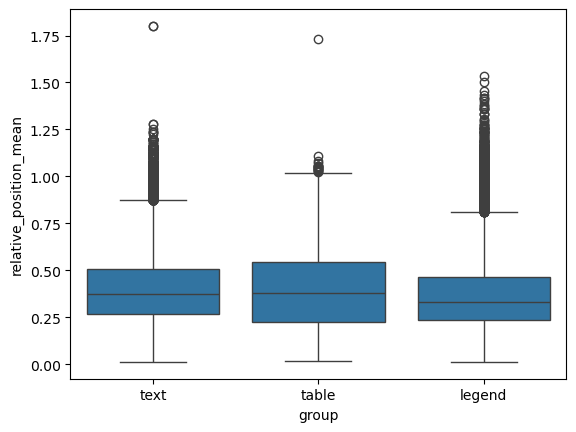

In [27]:
# Boxplot of relative_position_mean ditribution according to the unique category 
sns.boxplot(x='group', y='relative_position_mean', data=unique_group)


# 2. Creation of a networkX with target people and all the path that lead to it <a id="section2"></a>

We wanted to visualise the path leading to each People target to analyse their behaviour. Spoiler: the comparison of 631 distinct plots is not the most efficient way to look at our data. As obvious as it may seem, we, however, created a function to do the plot before realising that. In theory, we wanted to put the target node in evidence and all around it, each path, with the primary category colour for each node. In reality, it doesn’t look as nice as expected, for various reasons such as the presence of return in the paths or just because they are highly connected.

We noticed something from those plots: the targets tend to be reached by a limited number of links. This observation motivated us to narrow down our research not by looking at the whole path but at only a small part of it. 

In [28]:
# Function to split the list based on '.' prefix
def split_list_on_prefix(row):
    list_ = []
    row_ = []
    for word in row:
        if word.startswith('.'):
            row_.append(list_)
            list_ = [word[1:]]
        else:
            list_.append(word)  
    row_.append(list_)
    return row_

In [29]:
# Create a list with all the peopls name
list_people = dfs['categories'].copy()[dfs['categories']['category'].str.contains('subject.People.')].article

# Look for all the finished path that target a people from the above list
path_target_people = pd.DataFrame(dfs['paths_finished'].path.copy().str.split(';'))
path_target_people['target'] = path_target_people.path.apply(lambda x: x[-1])
path_target_people = path_target_people[path_target_people.target.isin(list_people)]

#Remove all the path of length 1 (directly on the correct page)
path_target_people = path_target_people[path_target_people['path'].apply(lambda x: len(x) >= 2)]

# Separate the case of returns into list of list
path_target_people.path = [split_list_on_prefix(r) for r in path_target_people.path]

# Count the occurence of each name in target
target_distribution = path_target_people.target.value_counts()
path_target_people = path_target_people.merge(target_distribution, on = 'target', how = 'left')

target_people_list = path_target_people.target.drop_duplicates()
print(len(list_people), len(target_people_list))
display(target_people_list)

689 454


0              John_F._Kennedy
2       Elizabeth_I_of_England
7          Henry_David_Thoreau
8           Buckminster_Fuller
9          James_II_of_England
                 ...          
4254            Witold_Pilecki
4296            Donald_Bradman
4686              Sandy_Koufax
4738            Hannibal_Barca
5011               Franz_Kafka
Name: target, Length: 454, dtype: object

In [30]:
def get_cat(Node):
    try:
        return result_dict[Node]["main_subject"]
    except KeyError as e:
        return np.nan

def get_color(Node):
    try:
        return map_cat_to_color[result_dict[Node]["main_subject"]]
    except KeyError as e:
        return "#FFFFFF"


all_cat = ['Science', 'Geography', 'People', 'History', 'Everyday_life', 'Citizenship', 'Design_and_Technology', 'Countries', 'Language_and_literature', 'Religion', 'Music', 'IT', 'Business_Studies', 'Mathematics', 'Art', None]
colors = list(mcd.XKCD_COLORS.values())[::7]
map_cat_to_color = {}
for i in range(len(all_cat)):
    map_cat_to_color[all_cat[i]] = colors[i]

j = 0
source_list = []

for people in target_people_list.iloc[7:17]:
    graph = nx.MultiDiGraph()
    target_article = people
    print(target_article)
    source_list = []

    #Find all the path that this target have
    for i, path in path_target_people[path_target_people.target == people].iterrows():
        # Need to add the path of each nodes
        path_target = path.path
        # Handle return case
        for j in range(len(path_target)):
 
            #Iterate to each words of the (partial) list
            partial_path = path_target[j]
            for k in range(len(partial_path)-1):
                target = partial_path[k+1]
                if target != target_article:
    
                    target = target
                # Add edges to the graph
                cur_nod = partial_path[k]
                if k == 0: 
                    source_list.append(cur_nod)
                graph.add_edge(cur_nod, target)
                graph.add_node(cur_nod)


    plt.figure(figsize=(8, 4))
    pos = nx.nx_agraph.graphviz_layout(G = graph.subgraph(set(graph) - {target_article}), prog="twopi", root=0)
    pos[target_article] = np.array([0, 0])

    #node size
    nd = 100
    color_noded = 'skyblue'
    node_names = list(graph.nodes())

    node_colors = [get_color(node) for node in node_names]
    color_of_target = get_color(target_article)
    color_of_source = [get_color(node) for node in source_list]
    print(color_of_source)

    color_edge_target = 'red'
    color_edge_source = 'green'
    #nx.flow_hierarchy(graph)
    nx.draw(graph, pos, with_labels=False, node_size=nd, node_color= node_colors, nodelist=node_names,  font_size=5, font_color='black', font_weight='bold', arrowsize=8, alpha = 0.2)
    nx.draw_networkx_nodes(graph, pos, nodelist=[target_article], node_color= color_of_target,  edgecolors = color_edge_target, node_size=nd, linewidths=2)
    nx.draw_networkx_nodes(graph, pos, nodelist=source_list, node_color= color_of_source, edgecolors=color_edge_source, node_size=nd, linewidths=2, alpha = 0.5)
    
    # Create a custom legend using the color map
    legend_labels = [f'{cat}' for cat in all_cat]  # Unicode character for a filled circle
    legend_colors = [map_cat_to_color[cat] for cat in all_cat]
    legend_markers = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]
    plt.legend(legend_markers, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()


Martina_Navratilova


ImportError: requires pygraphviz http://pygraphviz.github.io/

<Figure size 800x400 with 0 Axes>